Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [106]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from IPython.display import display, Image, Markdown, clear_output
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [10]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  train_labels_reg = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels_reg = save['valid_labels']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [11]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [12]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### L2 with linear regression

In [14]:
# sizes = (50, 100, 1000)
# params = { "C": (0.07, 0.08, 0.1) }
params = { "C": (0.006, 0.07) }
sizes = (20000,)

for size in sizes:
        
    # Fit regressor
    regressor = LogisticRegression()
    regressor.fit(train_dataset[0: size], train_labels_reg[0: size])
    score = regressor.score(valid_dataset, valid_labels_reg)
    print("Score before optimization: %f" % score)
    
    grid_search = GridSearchCV(regressor, params)
    print("Executing grid search...")
    grid_search.fit(train_dataset[:size], train_labels_reg[0:size])
    
    # Get result
    score = grid_search.score(valid_dataset, valid_labels_reg)
    print("Training with size %i had score %f" % (size, score))
    print("best params for estimator: %s" % grid_search.best_params_)
    

Score before optimization: 0.811200
Executing grid search...
Training with size 20000 had score 0.822500
best params for estimator: {'C': 0.07}


### L2 with tf deep net

In [104]:
batch_size = 128
hidden_units = 1024
l2_loss_amount = 5e-3

graph = tf.Graph()
with graph.as_default():

  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_units]))
  biases = tf.Variable(tf.zeros([hidden_units]))
  # Last layer vars
  weights_h1 = tf.Variable(tf.truncated_normal([hidden_units, num_labels]))
  biases_h1 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
  # Hidden layer
  logits = tf.matmul(layer1, weights_h1) + biases_h1

  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) +
      # Apply L2 regularization to the loss
      l2_loss_amount*tf.nn.l2_loss(weights) + l2_loss_amount*tf.nn.l2_loss(weights_h1))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_prediction, weights_h1) + biases_h1)

  test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(test_prediction, weights_h1) + biases_h1)

# Run session

minibatch_acc = [];
val_acc = [];
test_acc = [];

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(3001):
    # Pick an offset within the training data, which has been randomized.
    offset = (step * batch_size * time()) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    # Generate chart
    if (step % 100 == 0):
      m_acc = accuracy(predictions, batch_labels)
      minibatch_acc.append(m_acc)
      v_acc = accuracy(valid_prediction.eval(), valid_labels)
      val_acc.append(v_acc)
      t_acc = accuracy(test_prediction.eval(), test_labels)
      test_acc.append(t_acc)

    if (step % 500 == 0):

      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % m_acc)
      print("Validation accuracy: %.1f%%" % v_acc)

  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

<IPython.core.display.Javascript object>


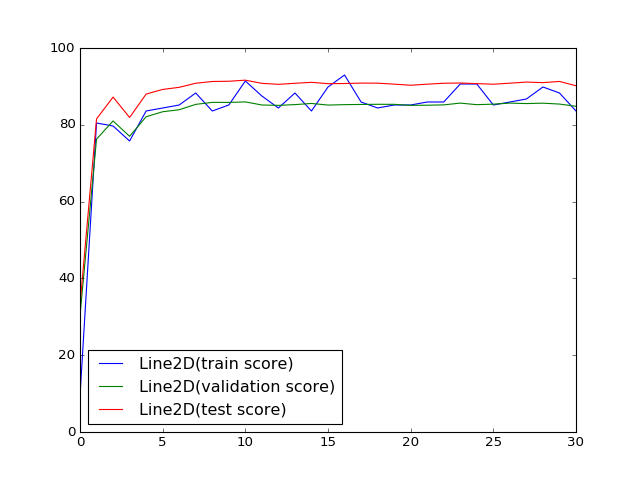

In [79]:
handle1, = plt.plot(minibatch_acc, label="train score")
handle2, = plt.plot(val_acc, label="validation score")
handle3, = plt.plot(test_acc, label="test score")
plt.legend([handle1, handle2, handle3], loc="best")
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Initialized


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


...............................Test accuracy: 86.8%


<IPython.core.display.Javascript object>


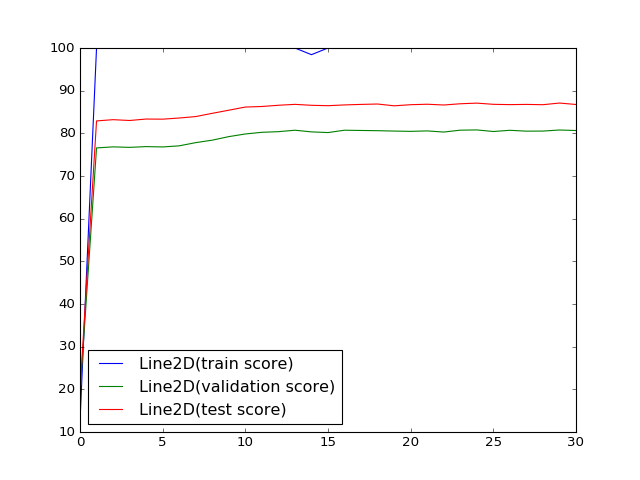

In [105]:
minibatch_acc = [];
val_acc = [];
test_acc = [];

overfit_train_dataset = train_dataset[0:1000]
overfit_train_labels = train_labels[0:1000]

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(3001):
    
    offset = (step * batch_size * time()) % (overfit_train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = overfit_train_dataset[offset:(offset + batch_size), :]
    batch_labels = overfit_train_labels[offset:(offset + batch_size), :]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    # Generate chart
    if (step % 100 == 0):
      minibatch_acc.append(accuracy(predictions, batch_labels))
      val_acc.append(accuracy(valid_prediction.eval(), valid_labels))
      test_acc.append(accuracy(test_prediction.eval(), test_labels))
      print(".", end="")

  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

handle1, = plt.plot(minibatch_acc, label="train score")
handle2, = plt.plot(val_acc, label="validation score")
handle3, = plt.plot(test_acc, label="test score")
plt.legend([handle1, handle2, handle3], loc="best")
plt.show()

Not having enough data to train obviously overfits.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [99]:
batch_size = 128
hidden_units = 1024
l2_loss_amount = 5e-3

graph = tf.Graph()
with graph.as_default():

  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_units]))
  biases = tf.Variable(tf.zeros([hidden_units]))
  # Last layer vars
  weights_h1 = tf.Variable(tf.truncated_normal([hidden_units, num_labels]))
  biases_h1 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
  # Second hidden layer
  logits = tf.nn.dropout(tf.matmul(layer1, weights_h1) + biases_h1, 0.9)

  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) +
      # Apply L2 regularization to the loss
      l2_loss_amount*tf.nn.l2_loss(weights) + l2_loss_amount*tf.nn.l2_loss(weights_h1))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_prediction, weights_h1) + biases_h1)

  test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(test_prediction, weights_h1) + biases_h1)

# Run session
minibatch_acc = [];
val_acc = [];
test_acc = [];

overfit_train_dataset = train_dataset[0:1000]
overfit_train_labels = train_labels[0:1000]

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(3001):
    
    offset = (step * batch_size * time()) % (overfit_train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = overfit_train_dataset[offset:(offset + batch_size), :]
    batch_labels = overfit_train_labels[offset:(offset + batch_size), :]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    # Generate chart
    if (step % 100 == 0):
      minibatch_acc.append(accuracy(predictions, batch_labels))
      val_acc.append(accuracy(valid_prediction.eval(), valid_labels))
      test_acc.append(accuracy(test_prediction.eval(), test_labels))
      print(".", end="")

  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


...............................Test accuracy: 86.9%


<IPython.core.display.Javascript object>


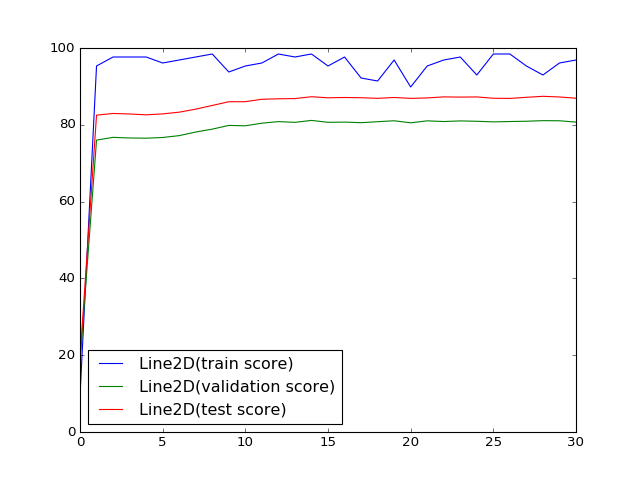

In [102]:
handle1, = plt.plot(minibatch_acc, label="train score")
handle2, = plt.plot(val_acc, label="validation score")
handle3, = plt.plot(test_acc, label="test score")
plt.legend([handle1, handle2, handle3], loc="best")
plt.show()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Initialized


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Minibatch loss at step 0: 364528.625000
Minibatch accuracy: 10.2%
Validation accuracy: 10.0%


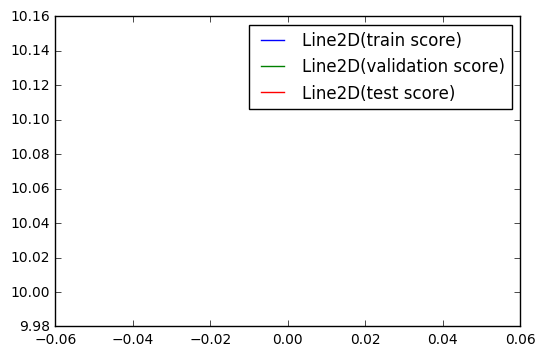

Minibatch loss at step 500: nan
Minibatch accuracy: 10.2%
Validation accuracy: 10.0%


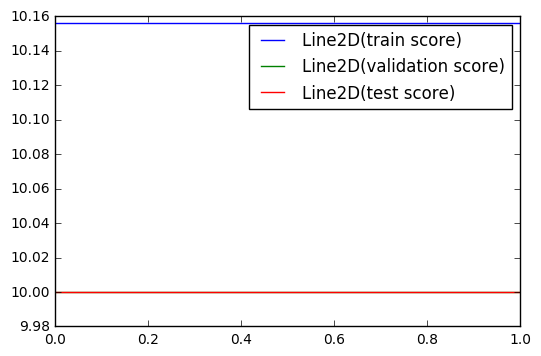

In [ ]:
batch_size = 128
hidden_units = 1024
l2_loss_amount = 5e-3
dropout_amount = 0.4

graph = tf.Graph()
with graph.as_default():

  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_units]))
  biases = tf.Variable(tf.zeros([hidden_units]))
  # Last layer vars
  weights_h1 = tf.Variable(tf.truncated_normal([hidden_units, hidden_units]))
  biases_h1 = tf.Variable(tf.zeros([hidden_units]))
  weights_h2 = tf.Variable(tf.truncated_normal([hidden_units, hidden_units]))
  biases_h2 = tf.Variable(tf.zeros([hidden_units]))
  weights_h3 = tf.Variable(tf.truncated_normal([hidden_units, num_labels]))
  biases_h3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
  layer2 = tf.nn.dropout(tf.nn.relu(tf.matmul(layer1, weights_h1) + biases_h1), dropout_amount)
  layer3 = tf.nn.dropout(tf.nn.relu(tf.matmul(layer2, weights_h2) + biases_h2), dropout_amount)
  logits = tf.matmul(layer3, weights_h3) + biases_h3

  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) +
      # Apply L2 regularization to the loss
      l2_loss_amount*tf.nn.l2_loss(weights) + l2_loss_amount*tf.nn.l2_loss(weights_h1))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.3).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  valid_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
  valid_prediction = tf.nn.relu(tf.matmul(valid_prediction, weights_h1) + biases_h1)
  valid_prediction = tf.nn.relu(tf.matmul(valid_prediction, weights_h2) + biases_h2)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_prediction, weights_h3) + biases_h3)

  test_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
  test_prediction = tf.nn.relu(tf.matmul(test_prediction, weights_h1) + biases_h1)
  test_prediction = tf.nn.relu(tf.matmul(test_prediction, weights_h2) + biases_h2)
  test_prediction = tf.nn.softmax(tf.matmul(test_prediction, weights_h3) + biases_h3)

# Run session
minibatch_acc = [];
val_acc = [];
test_acc = [];

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(3001):
    
    offset = (step * batch_size * time()) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    # Generate chart
    if (step % 500 == 0):
      clear_output()
    
      m_acc = accuracy(predictions, batch_labels)
      minibatch_acc.append(m_acc)
      v_acc = accuracy(valid_prediction.eval(), valid_labels)
      val_acc.append(v_acc)
      t_acc = accuracy(test_prediction.eval(), test_labels)
      test_acc.append(t_acc)

      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % m_acc)
      print("Validation accuracy: %.1f%%" % v_acc)

      handle1, = plt.plot(minibatch_acc, label="train score")
      handle2, = plt.plot(val_acc, label="validation score")
      handle3, = plt.plot(test_acc, label="test score")
      plt.legend([handle1, handle2, handle3], loc="best")
      plt.show()

  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))